In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GPT2Model
import torch
from torch import tensor

import numpy as np 
from scipy import linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from BufferGeometry import BufferGeometry

In [2]:
# Define the model and the tokenizer
model = GPT2Model.from_pretrained("openai-community/gpt2")
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model.eval()

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [3]:
prompt = "Three little monkeys jumping on the bed"

inputs = tokenizer(prompt, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True, output_attentions=True, return_dict=True)

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [4]:
# Access the attention layer
attention_weights = torch.stack(outputs.attentions) 
attention = torch.squeeze(attention_weights, dim=1).numpy() 

/var/folders/9p/sxfs2z3j2ln1p3kz5qdq03_w0000gn/T/ipykernel_3022/1750881577.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


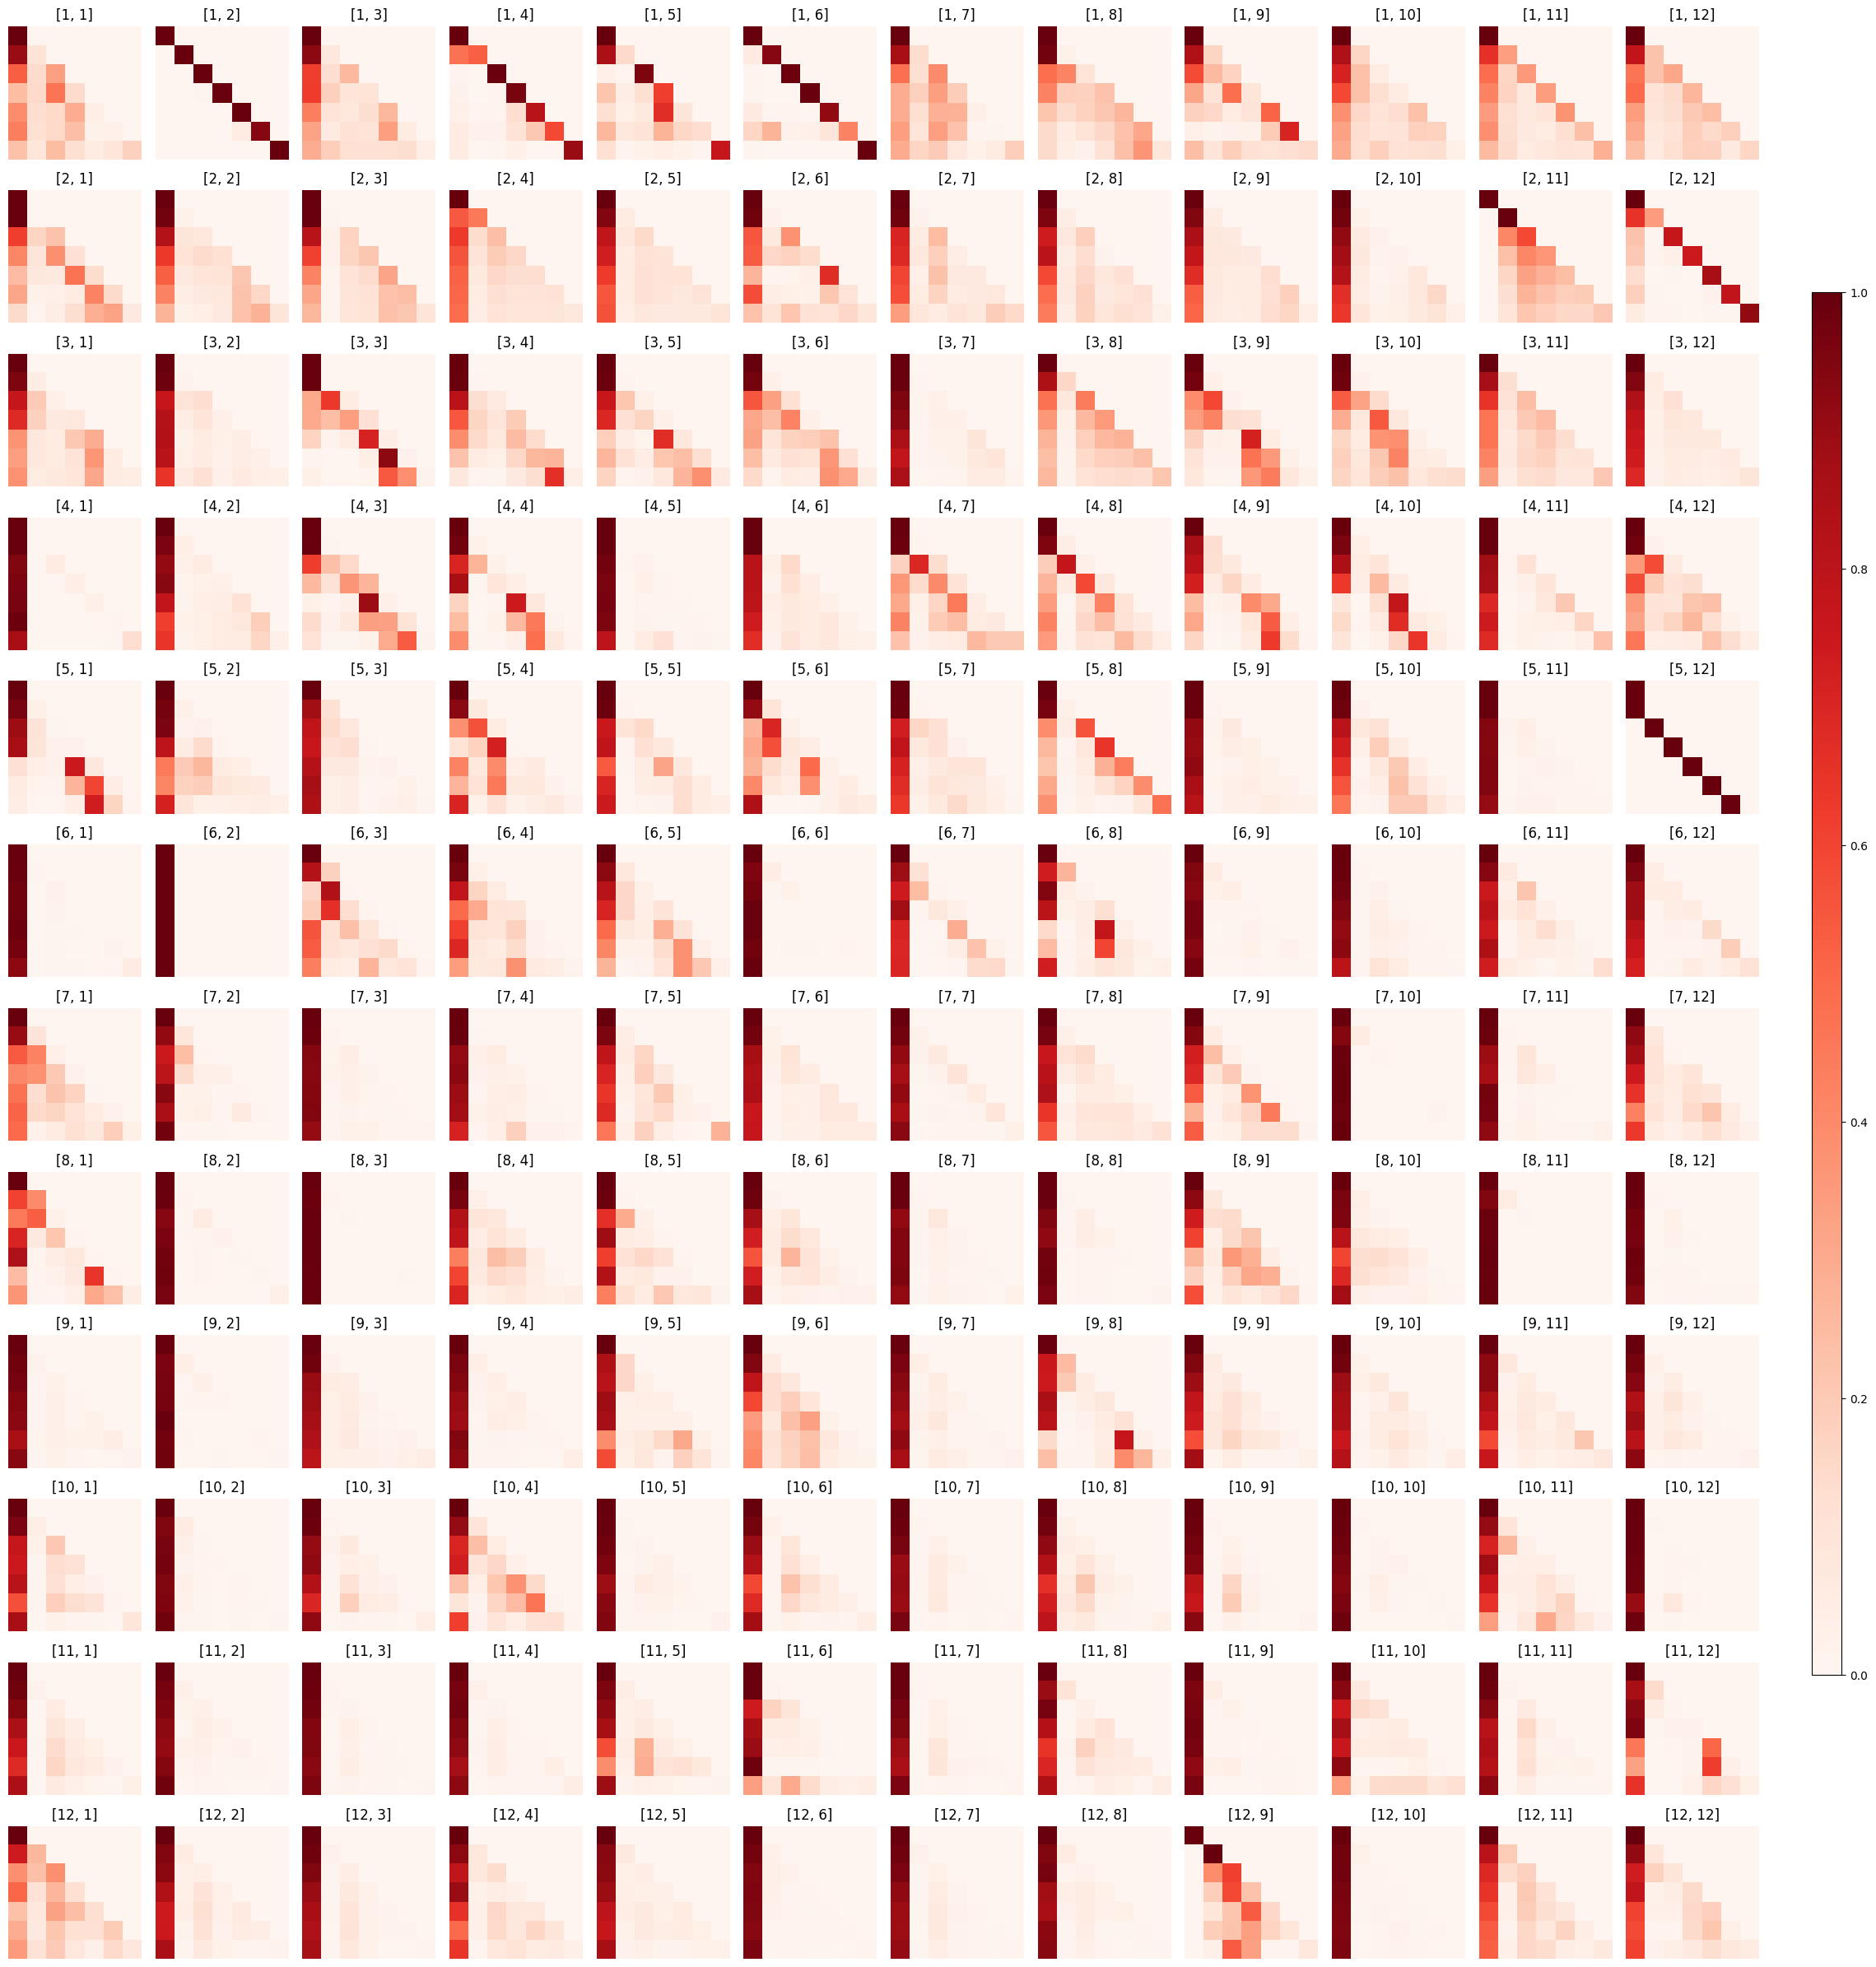

In [5]:
fig, ax = plt.subplots(12, 12, figsize=(24, 24))

for l1 in range(12):
    for l2 in range(12):
        im = ax[l1, l2].imshow(attention[l1, l2], cmap="Reds")
        ax[l1, l2].set_title(f"[{l1+1}, {l2+1}]")
        ax[l1, l2].axis("off")


cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

In [6]:
buffer = outputs.last_hidden_state  
last_token = buffer[0, -1, :].unsqueeze(0).numpy()

# Reshape it to use it with the multi head mechanism
head_dim = last_token.shape[1] // attention.shape[1]
last_token = last_token.reshape(attention.shape[1], head_dim)

In [7]:
print(np.shape(attention)) # (layers, heads, prompt length, prompt length)
print(np.shape(last_token)) 

(12, 12, 7, 7)
(12, 64)
